# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [1]:
import tensorflow as tf

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170498071/170498071 [==============================] - 3s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

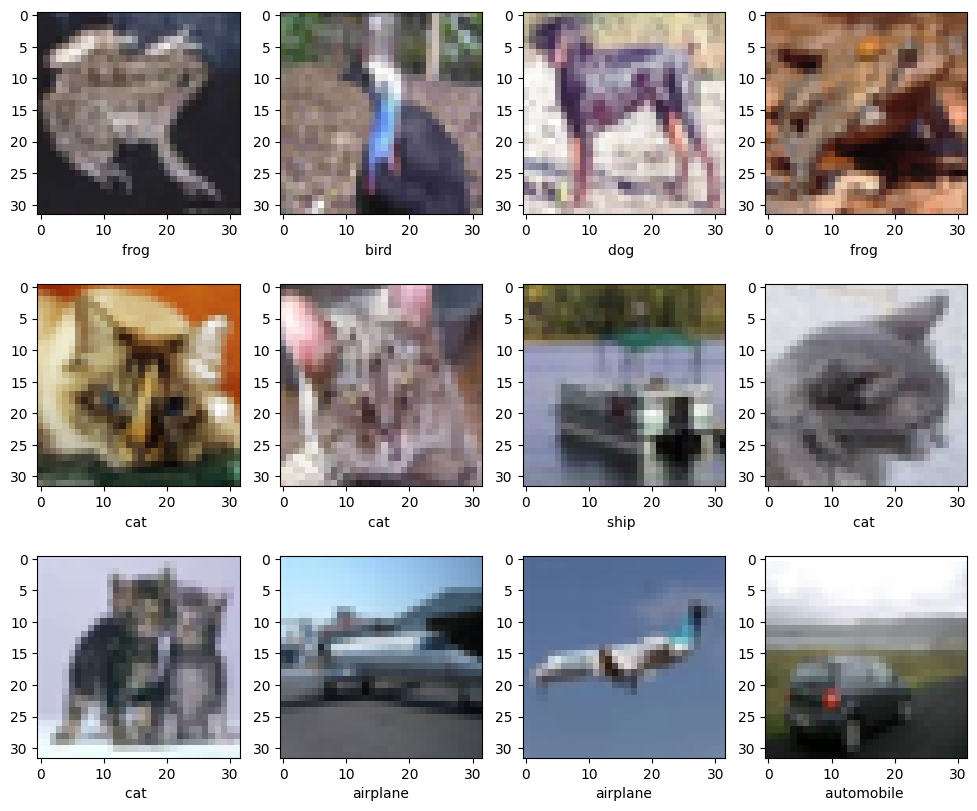

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [7]:
model = tf.keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(3072, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
    )

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 3072)              9440256   
                                                                 
 dense_1 (Dense)             (None, 10)                30730     
                                                                 
Total params: 9,470,986
Trainable params: 9,470,986
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [10]:
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1000/1000 [==============================] - 175s 174ms/step - loss: 2.4351 - accuracy: 0.2778 - val_loss: 1.8530 - val_accuracy: 0.3332
Epoch 2/5
1000/1000 [==============================] - 173s 173ms/step - loss: 1.7650 - accuracy: 0.3720 - val_loss: 1.7256 - val_accuracy: 0.3764
Epoch 3/5
1000/1000 [==============================] - 173s 173ms/step - loss: 1.6830 - accuracy: 0.4029 - val_loss: 1.7204 - val_accuracy: 0.3856
Epoch 4/5
1000/1000 [==============================] - 178s 178ms/step - loss: 1.6356 - accuracy: 0.4200 - val_loss: 1.7194 - val_accuracy: 0.3930
Epoch 5/5
1000/1000 [==============================] - 174s 174ms/step - loss: 1.5990 - accuracy: 0.4348 - val_loss: 1.6386 - val_accuracy: 0.4198


In [11]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print('Успех!')

1/1 [==============================] - 0s 98ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [21]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [60]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [61]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    keras.callbacks.LearningRateScheduler(scheduler),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [23]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy']
)
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=10,
          validation_split=0.2,
          validation_data=[X_val, y_val])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 [==============================] - 232s 186ms/step - loss: 1.5899 - accuracy: 0.4377 - val_loss: 1.6556 - val_accuracy: 0.4161
Epoch 2/10
1250/1250 [==============================] - 223s 179ms/step - loss: 1.5637 - accuracy: 0.4474 - val_loss: 1.6123 - val_accuracy: 0.4336
Epoch 3/10
1250/1250 [==============================] - 221s 177ms/step - loss: 1.5402 - accuracy: 0.4561 - val_loss: 1.5896 - val_accuracy: 0.4367
Epoch 4/10
1250/1250 [==============================] - 221s 177ms/step - loss: 1.5208 - accuracy: 0.4602 - val_loss: 1.5664 - val_accuracy: 0.4516
Epoch 5/10
1250/1250 [==============================] - 220s 176ms/step - loss: 1.5051 - accuracy: 0.4688 - val_loss: 1.6042 - val_accuracy: 0.4360
Epoch 6/10
1250/1250 [==============================] - 221s 177ms/step - loss: 1.4940 - accuracy: 0.4751 - val_loss: 1.5750 - val_accuracy: 0.4574
Epoch 7/10
1250/1250 [==============================] - 220s 176ms/step - loss: 1.4791 - accuracy: 0.4792 - val_loss: 1.553

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [24]:
from sklearn.metrics import accuracy_score
predict_x=model.predict(X_test)
model_predict_classes_=np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, model_predict_classes_)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 8s 26ms/step

 Test_acc = 0.4645
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [25]:
model_cnn = tf.keras.models.Sequential([
    L.Conv2D(filters=10,
             kernel_size=(3, 3),
             padding='same',
             activation='relu',
             input_shape=(32,32,3)),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model_cnn.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=7,
          validation_split=0.2,
          validation_data=[X_val, y_val])

Epoch 1/7
1250/1250 [==============================] - 32s 25ms/step - loss: 1.5798 - accuracy: 0.4364 - val_loss: 1.3354 - val_accuracy: 0.5301
Epoch 2/7
1250/1250 [==============================] - 34s 27ms/step - loss: 1.2771 - accuracy: 0.5509 - val_loss: 1.2402 - val_accuracy: 0.5631
Epoch 3/7
1250/1250 [==============================] - 33s 26ms/step - loss: 1.1849 - accuracy: 0.5872 - val_loss: 1.3062 - val_accuracy: 0.5466
Epoch 4/7
1250/1250 [==============================] - 34s 27ms/step - loss: 1.1127 - accuracy: 0.6091 - val_loss: 1.1982 - val_accuracy: 0.5785
Epoch 5/7
1250/1250 [==============================] - 31s 24ms/step - loss: 1.0584 - accuracy: 0.6294 - val_loss: 1.1931 - val_accuracy: 0.5897
Epoch 6/7
1250/1250 [==============================] - 33s 27ms/step - loss: 1.0095 - accuracy: 0.6468 - val_loss: 1.1429 - val_accuracy: 0.6033
Epoch 7/7
1250/1250 [==============================] - 31s 25ms/step - loss: 0.9695 - accuracy: 0.6595 - val_loss: 1.1358 - val_ac

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [27]:
from sklearn.metrics import accuracy_score
predict_x=model_cnn.predict(X_test)
model_predict_classes_=np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, model_predict_classes_)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.6103
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [15]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from tqdm.notebook import tqdm 

In [49]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=10, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            predict_x=model.predict(X_test)
            model_predict_classes_=np.argmax(predict_x, axis=1)
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model_predict_classes_)))

In [50]:
!rm -rf ./logs

In [51]:
optimizers = {
    'optimizer_adam': 'adam', 
    'optimizer_sgd': 'sgd',
    'optimizer_RMSprop': 'RMSprop'
}

In [24]:
evaluator = Evaluator(model_cnn, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 2s 7ms/step
Final score of single_model_optimizer_adam is 0.6029
313/313 [==============================] - 2s 7ms/step
Final score of single_model_optimizer_sgd is 0.5717
313/313 [==============================] - 4s 11ms/step
Final score of single_model_optimizer_RMSprop is 0.6227


Прокомментируйте полученные результаты.

In [25]:
#Самая высокая accuracy у RMSprop. Довольно любобпытно, что при первой попытке, выше accuracy показал sgd, при второй - adam, а вот теперь RMSprop

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [52]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [53]:
model_batch_norm_1 = keras.Sequential([
    L.Conv2D(filters=10,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

In [54]:
model_batch_norm_2 = keras.Sequential([
    L.Conv2D(filters=10,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

In [55]:
model_batch_norm_3 = keras.Sequential([
    L.Conv2D(filters=10,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

In [56]:
model_bn_dict = {'BatchNormalization_act': model_batch_norm_1,
                 'BatchNormalization_fully_conv': model_batch_norm_2,
                 'BatchNormalization_both_layers': model_batch_norm_3}

In [31]:
for key, val in model_bn_dict.items():
    val.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    val.fit(X_train,
            y_train,
            batch_size=32,
            validation_split=0.2,
            epochs=7,
            validation_data=[X_val, y_val])
    
    y_pred = [np.argmax(prob) for prob in val.predict(X_test)]
    test_acc = accuracy_score(y_test, y_pred)
    print(f'\n Test_acc в зависимости от {key}:', test_acc)

Epoch 1/7
1250/1250 [==============================] - 43s 34ms/step - loss: 1.4894 - accuracy: 0.4733 - val_loss: 1.3361 - val_accuracy: 0.5381
Epoch 2/7
1250/1250 [==============================] - 26s 21ms/step - loss: 1.2340 - accuracy: 0.5644 - val_loss: 1.3295 - val_accuracy: 0.5353
Epoch 3/7
1250/1250 [==============================] - 28s 22ms/step - loss: 1.1190 - accuracy: 0.6097 - val_loss: 1.4524 - val_accuracy: 0.5089
Epoch 4/7
1250/1250 [==============================] - 26s 21ms/step - loss: 1.0370 - accuracy: 0.6373 - val_loss: 1.2439 - val_accuracy: 0.5720
Epoch 5/7
1250/1250 [==============================] - 27s 22ms/step - loss: 0.9663 - accuracy: 0.6620 - val_loss: 1.2179 - val_accuracy: 0.5816
Epoch 6/7
1250/1250 [==============================] - 27s 21ms/step - loss: 0.9125 - accuracy: 0.6806 - val_loss: 1.2561 - val_accuracy: 0.5765
Epoch 7/7
313/313 [==============================] - 3s 8ms/step

 Test_acc в зависимости от BatchNormalization_act: 0.5891
Epoch 

Прокомментируйте полученные результаты.

In [32]:
#accuracy лучше всего у BatchNormalization_both_layers

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

  0%|          | 0/6 [00:00<?, ?it/s]

Batch size: 4
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


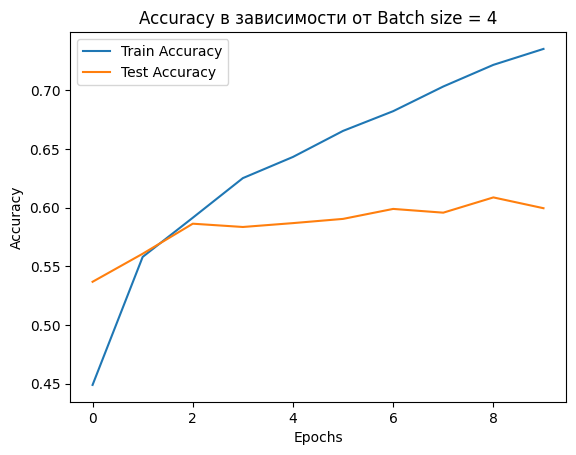

Batch size: 8
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


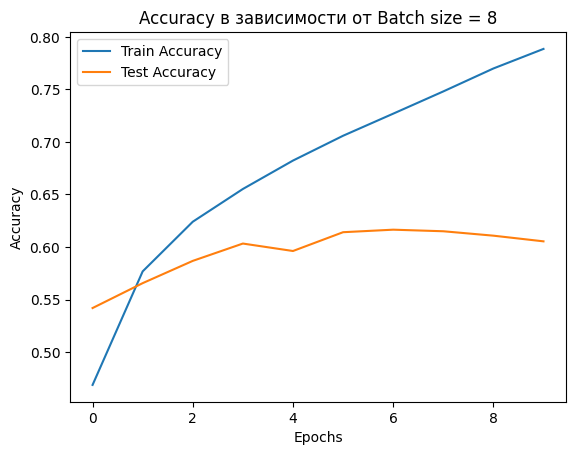

Batch size: 16
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


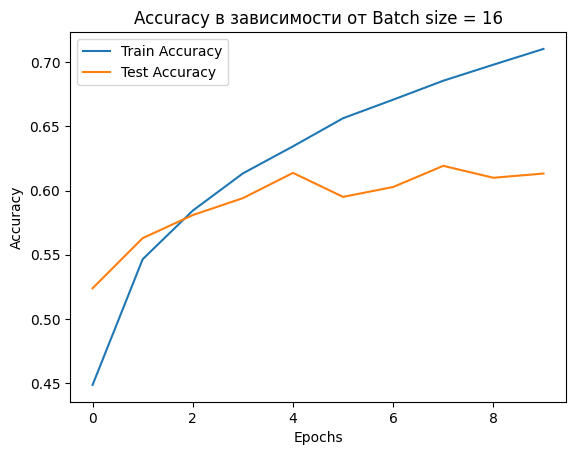

Batch size: 32
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


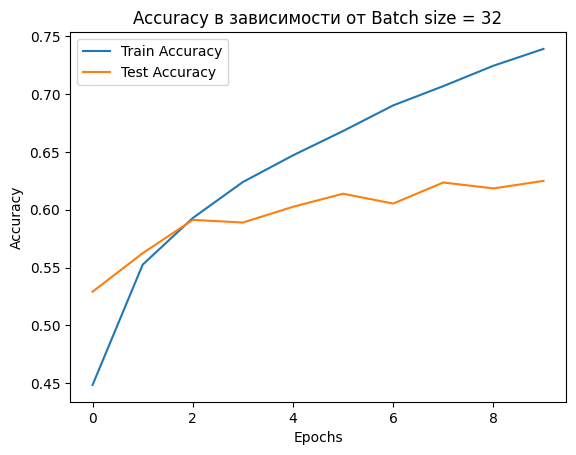

Batch size: 64
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


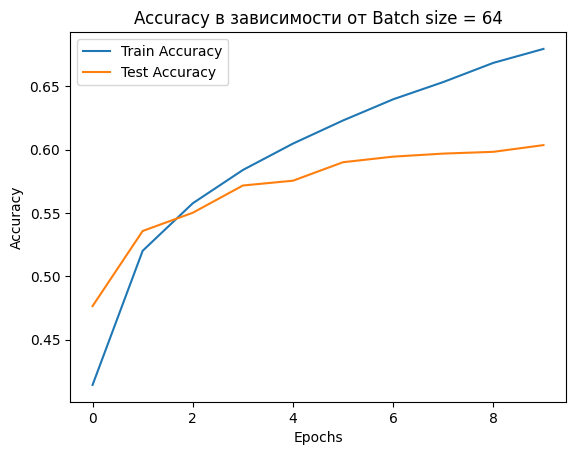

Batch size: 128
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


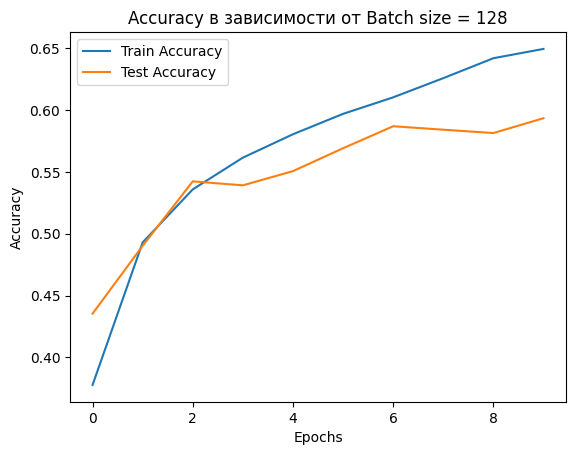

In [33]:
batch_sizes_list = [4, 8, 16, 32, 64, 128]

callback = keras.callbacks.EarlyStopping(monitor='accuracy', mode = 'max', baseline=0.55, patience = 3, restore_best_weights=True)

for batch_size in tqdm(batch_sizes_list):
    print('Batch size:', batch_size)
    model = keras.Sequential([
        L.Conv2D(filters=10,
                      kernel_size=(3, 3),
                      padding='same',
                      activation='relu',
                      input_shape=(32, 32, 3)),
        L.MaxPool2D(pool_size=(2, 2), padding='valid'),
        L.Flatten(),
        L.Dense(100, activation='relu'),
        L.Dense(10, activation='softmax')])
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(X_train,
               y_train,
               batch_size = batch_size,
               validation_split=0.2,
               verbose=3,
               epochs=10,
               callbacks=[callback],
               validation_data=[X_val, y_val])
    
    plt.plot(model.history.history['accuracy'],label='Train Accuracy')
    plt.plot(model.history.history['val_accuracy'],label='Test Accuracy')
    plt.legend()
    plt.title(f'Accuracy в зависимости от Batch size = {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [34]:
# самая высокая accuracy у batch_size = 32, возможно, для batch_size = 128 не хватило эпох, така как кривая test accuracy продолжала расти на 10 эпохе

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [57]:
evaluator = Evaluator(model_bn_dict, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/9 [00:00<?, ?it/s]

313/313 [==============================] - 3s 9ms/step
Final score of BatchNormalization_act_optimizer_adam is 0.6211
313/313 [==============================] - 3s 9ms/step
Final score of BatchNormalization_act_optimizer_sgd is 0.5692
313/313 [==============================] - 3s 9ms/step
Final score of BatchNormalization_act_optimizer_RMSprop is 0.592
313/313 [==============================] - 3s 11ms/step
Final score of BatchNormalization_fully_conv_optimizer_adam is 0.5361
313/313 [==============================] - 5s 15ms/step
Final score of BatchNormalization_fully_conv_optimizer_sgd is 0.5682
313/313 [==============================] - 3s 10ms/step
Final score of BatchNormalization_fully_conv_optimizer_RMSprop is 0.5567
313/313 [==============================] - 3s 10ms/step
Final score of BatchNormalization_both_layers_optimizer_adam is 0.5812
313/313 [==============================] - 6s 17ms/step
Final score of BatchNormalization_both_layers_optimizer_sgd is 0.5945
313/313 [===

In [36]:
#лучше всего сработало сочетание: BatchNormalization_act и optimizer_adam

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [37]:
#Добавим побольше фильтров

In [38]:
model_try_1 = keras.Sequential([
    L.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

model_try_1.compile(optimizer='adam',
                    loss=' categorical_crossentropy',
                    metrics=['accuracy'])

model_try_1.fit(X_train,
                y_train,
                batch_size=32,
                validation_split=0.2,
                verbose=2,
                epochs=10,
                validation_data=[X_val, y_val])

Epoch 1/10
1250/1250 - 146s - loss: 1.3046 - accuracy: 0.5393 - val_loss: 1.1312 - val_accuracy: 0.6087 - 146s/epoch - 116ms/step
Epoch 2/10
1250/1250 - 145s - loss: 0.9143 - accuracy: 0.6797 - val_loss: 1.1364 - val_accuracy: 0.6129 - 145s/epoch - 116ms/step
Epoch 3/10
1250/1250 - 148s - loss: 0.7275 - accuracy: 0.7473 - val_loss: 0.9718 - val_accuracy: 0.6678 - 148s/epoch - 118ms/step
Epoch 4/10
1250/1250 - 143s - loss: 0.5605 - accuracy: 0.8059 - val_loss: 1.0132 - val_accuracy: 0.6723 - 143s/epoch - 115ms/step
Epoch 5/10
1250/1250 - 145s - loss: 0.4211 - accuracy: 0.8553 - val_loss: 1.0971 - val_accuracy: 0.6766 - 145s/epoch - 116ms/step
Epoch 6/10
1250/1250 - 146s - loss: 0.3091 - accuracy: 0.8937 - val_loss: 1.2964 - val_accuracy: 0.6459 - 146s/epoch - 117ms/step
Epoch 7/10
1250/1250 - 145s - loss: 0.2395 - accuracy: 0.9188 - val_loss: 1.3350 - val_accuracy: 0.6743 - 145s/epoch - 116ms/step
Epoch 8/10
1250/1250 - 143s - loss: 0.1816 - accuracy: 0.9388 - val_loss: 1.5168 - val_acc

In [39]:
#Добавим больше фильтров, слоёв и dropout

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',  patience=5, restore_best_weights=True)

In [41]:
model_try_2 = keras.Sequential([
    L.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Dropout(0.2),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(2, 2)),
    L.Dropout(0.3),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

model_try_2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_try_2.fit(X_train,
                y_train,
                batch_size=32,
                validation_split=0.2,
                verbose=2,
                epochs=20,
                callbacks=[callback],
                validation_data=[X_val, y_val])

Epoch 1/20
1250/1250 - 273s - loss: 1.3248 - accuracy: 0.5347 - val_loss: 1.0831 - val_accuracy: 0.6238 - 273s/epoch - 218ms/step
Epoch 2/20
1250/1250 - 262s - loss: 0.9199 - accuracy: 0.6783 - val_loss: 1.2706 - val_accuracy: 0.5843 - 262s/epoch - 209ms/step
Epoch 3/20
1250/1250 - 265s - loss: 0.7716 - accuracy: 0.7295 - val_loss: 0.8816 - val_accuracy: 0.6966 - 265s/epoch - 212ms/step
Epoch 4/20
1250/1250 - 258s - loss: 0.6808 - accuracy: 0.7623 - val_loss: 0.7511 - val_accuracy: 0.7397 - 258s/epoch - 207ms/step
Epoch 5/20
1250/1250 - 259s - loss: 0.6059 - accuracy: 0.7896 - val_loss: 0.9629 - val_accuracy: 0.6869 - 259s/epoch - 208ms/step
Epoch 6/20
1250/1250 - 262s - loss: 0.5388 - accuracy: 0.8116 - val_loss: 0.7014 - val_accuracy: 0.7618 - 262s/epoch - 209ms/step
Epoch 7/20
1250/1250 - 258s - loss: 0.4900 - accuracy: 0.8278 - val_loss: 1.3126 - val_accuracy: 0.6080 - 258s/epoch - 207ms/step
Epoch 8/20
1250/1250 - 265s - loss: 0.4358 - accuracy: 0.8485 - val_loss: 0.6846 - val_acc

In [ ]:
# accuracy заметно выросла

In [42]:
#Изменим kernel_size

In [43]:
model_try_3 = keras.Sequential([
    L.Conv2D(filters=32,kernel_size=(5, 5),padding='same',activation='relu',input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Dropout(0.2),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(2, 2)),
    L.Dropout(0.3),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

model_try_3.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_try_3.fit(X_train,
                y_train,
                batch_size=32,
                validation_split=0.2,
                verbose=2,
                epochs=20,
                callbacks=[callback],
                validation_data=[X_val, y_val])

Epoch 1/20
1250/1250 - 439s - loss: 1.4275 - accuracy: 0.4946 - val_loss: 1.5328 - val_accuracy: 0.4879 - 439s/epoch - 351ms/step
Epoch 2/20
1250/1250 - 439s - loss: 1.0113 - accuracy: 0.6448 - val_loss: 1.1651 - val_accuracy: 0.5992 - 439s/epoch - 351ms/step
Epoch 3/20
1250/1250 - 438s - loss: 0.8506 - accuracy: 0.7028 - val_loss: 0.9914 - val_accuracy: 0.6553 - 438s/epoch - 351ms/step
Epoch 4/20
1250/1250 - 438s - loss: 0.7454 - accuracy: 0.7405 - val_loss: 0.8210 - val_accuracy: 0.7127 - 438s/epoch - 350ms/step
Epoch 5/20
1250/1250 - 447s - loss: 0.6730 - accuracy: 0.7643 - val_loss: 0.9228 - val_accuracy: 0.6949 - 447s/epoch - 357ms/step
Epoch 6/20
1250/1250 - 450s - loss: 0.6009 - accuracy: 0.7901 - val_loss: 0.7993 - val_accuracy: 0.7335 - 450s/epoch - 360ms/step
Epoch 7/20
1250/1250 - 422s - loss: 0.5497 - accuracy: 0.8054 - val_loss: 0.7942 - val_accuracy: 0.7360 - 422s/epoch - 338ms/step
Epoch 8/20
1250/1250 - 421s - loss: 0.4921 - accuracy: 0.8298 - val_loss: 0.7460 - val_acc

In [ ]:
#Без увеличения kernel size аccuracy росла быстрее. Тут она чуть выше. Время прохождения эпохи сильно выросло

In [44]:
#Заменим функцию активации

In [28]:
model_try_4 = keras.Sequential([
    L.Conv2D(filters=32,kernel_size=(5, 5),padding='same',activation='gelu',input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(5, 5), activation='gelu', padding='same'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Dropout(0.2),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='gelu', padding='same'),
    L.BatchNormalization(),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='gelu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(2, 2)),
    L.Dropout(0.3),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='gelu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

model_try_4.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_try_4.fit(X_train,
                y_train,
                batch_size=32,
                validation_split=0.2,
                verbose=2,
                epochs=20,
                callbacks=[callback],
                validation_data=[X_val, y_val])

Epoch 1/20
1250/1250 - 529s - loss: 1.4024 - accuracy: 0.5028 - val_loss: 1.3147 - val_accuracy: 0.5611 - 529s/epoch - 423ms/step
Epoch 2/20
1250/1250 - 531s - loss: 0.9753 - accuracy: 0.6569 - val_loss: 0.9616 - val_accuracy: 0.6693 - 531s/epoch - 424ms/step
Epoch 3/20
1250/1250 - 531s - loss: 0.8122 - accuracy: 0.7161 - val_loss: 0.9004 - val_accuracy: 0.6895 - 531s/epoch - 425ms/step
Epoch 4/20
1250/1250 - 552s - loss: 0.7083 - accuracy: 0.7515 - val_loss: 0.8121 - val_accuracy: 0.7162 - 552s/epoch - 442ms/step
Epoch 5/20
1250/1250 - 550s - loss: 0.6242 - accuracy: 0.7810 - val_loss: 0.7878 - val_accuracy: 0.7319 - 550s/epoch - 440ms/step
Epoch 6/20
1250/1250 - 548s - loss: 0.5602 - accuracy: 0.8036 - val_loss: 0.7727 - val_accuracy: 0.7355 - 548s/epoch - 438ms/step
Epoch 7/20
1250/1250 - 636s - loss: 0.5034 - accuracy: 0.8267 - val_loss: 0.7363 - val_accuracy: 0.7531 - 636s/epoch - 509ms/step
Epoch 8/20
1250/1250 - 604s - loss: 0.4514 - accuracy: 0.8419 - val_loss: 0.7783 - val_acc

In [30]:
# Увеличилось время прохождения эпохи, accuracy стала значительно ниже

In [29]:
# Добавим больше свёоточных слоёв, фильтров и dropout

In [34]:
model_perfect = keras.Sequential([
    L.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),
    L.Dropout(0.2),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(2, 2)),
    L.Dropout(0.3),
    L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(2, 2)),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

model_perfect.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_perfect.fit(X_train,
                y_train,
                batch_size=32,
                validation_split=0.2,
                verbose=2,
                epochs=70,
                callbacks=[callback],
                validation_data=[X_val, y_val])

Epoch 1/70
1250/1250 - 444s - loss: 1.3667 - accuracy: 0.5142 - val_loss: 1.1856 - val_accuracy: 0.5843 - 444s/epoch - 355ms/step
Epoch 2/70
1250/1250 - 428s - loss: 0.9178 - accuracy: 0.6788 - val_loss: 1.1882 - val_accuracy: 0.6167 - 428s/epoch - 342ms/step
Epoch 3/70
1250/1250 - 444s - loss: 0.7514 - accuracy: 0.7359 - val_loss: 0.9118 - val_accuracy: 0.6976 - 444s/epoch - 355ms/step
Epoch 4/70
1250/1250 - 433s - loss: 0.6490 - accuracy: 0.7733 - val_loss: 0.8624 - val_accuracy: 0.7284 - 433s/epoch - 346ms/step
Epoch 5/70
1250/1250 - 440s - loss: 0.5668 - accuracy: 0.8039 - val_loss: 1.2858 - val_accuracy: 0.6389 - 440s/epoch - 352ms/step
Epoch 6/70
1250/1250 - 422s - loss: 0.4969 - accuracy: 0.8266 - val_loss: 0.6791 - val_accuracy: 0.7723 - 422s/epoch - 337ms/step
Epoch 7/70
1250/1250 - 434s - loss: 0.4351 - accuracy: 0.8469 - val_loss: 0.6102 - val_accuracy: 0.8021 - 434s/epoch - 347ms/step
Epoch 8/70
1250/1250 - 432s - loss: 0.3887 - accuracy: 0.8628 - val_loss: 0.6435 - val_acc

Момент истины: проверьте, какого качества достигла ваша сеть.

In [35]:
predict_x = model_perfect.predict(X_test)
model_predict_classes_ = np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, model_predict_classes_)

print("\n Test_acc =", test_acc)

if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 24s 77ms/step

 Test_acc = 0.8015
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

In [ ]:
# Были построены несколько нейронныйх сетей с различными вариациями, 
# найболее эффективным оказалось использование свёрточной сети, нормализации на нескольких этапах и большего 
# количества слоёв с большим количеством фильтров, а так же применением dropout. 
# Обучение нейросетей довольно времязатратный процесс)